#  ScoutConnect: Soccer Player Market Value Prediction

## Mission:
The goal of this project is to build and deploy a regression model capable of accurately predicting the market value of a professional football player based on their performance, physical attributes, and technical skills. This model will be included in a ScoutConnect app i'm currently developing for my mission that helps connect young african talent to scouts and talent agencies. This model will assist scouts, agents, and clubs in making informed decisions about prospective talent.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import sqlite3

# Set style for professional visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("=== ScoutConnect: Football Player Market Value Prediction ===")

=== ScoutConnect: Football Player Market Value Prediction ===


## Data Acquisition & Focus on African Talent 

I am using a single, clean FIFA 23 Player Data Dataset

### The Key Step: Filtering for Our Mission
My mission is **ScoutConnect** for African talent. To make the model relevant to the "African market context," i couldn't train it on players from every country.

1.  **Define Target Region:** I made a simple list of all African nations.
2.  **Filter the Data:** Then I filtered the entire dataset to keep **only** players whose nationality matches the target list. This makes the model training focused and relevant to the assignment's goal.
3.  **Target Cleaning:** I cleaned the messy `Value` column to remove it text like currency symbols (e.g., "€20M") and turned it into a clean integer for regression.


In [2]:
def load_and_clean_data(file_path='Fifa 23 Players Data.csv'):
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Required dataset file '{file_path}' not found! Please download the FIFA stats dataset.")

    # Try different encodings
    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"Successfully loaded file with {encoding} encoding")
            break
        except UnicodeDecodeError:
            continue
    else:
        # If all encodings fail, try with error handling
        df = pd.read_csv(file_path, encoding='utf-8', errors='replace')
        print("Loaded file with error replacement for problematic characters")
    
    # Define African Nations for Filtering to focus on the project's target region.
    african_nations = [
        'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 
        'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 
        'Congo', 'DR Congo', 'Congo DR', 'Côte d\'Ivoire', 'Ivory Coast', 
        'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 
        'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 
        'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 
        'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 
        'Sao Tome & Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 
        'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 
        'Uganda', 'Zambia', 'Zimbabwe'
    ]
    
    # Filter for African players using the 'Country' column
    if 'Nationality' in df.columns: 
        df_filtered = df[df['Nationality'].isin(african_nations)].copy()
        print(f"Dataset filtered to {len(df_filtered)} players from African nations.")
    else:
        df_filtered = df.copy()
        print("WARNING: 'Nationality' column not found. Using the full global dataset. Check your column names!")

    df = df_filtered
    
    if 'Value(in Euro)' in df.columns:
        df = df[df['Value(in Euro)'].notna()]
        
        def clean_currency(value):
            if pd.isna(value):
                return 0
            if isinstance(value, str):
                # Remove currency symbols and clean the string
                value = value.replace('€', '').replace('$', '').replace(',', '').replace('.', '')
                try:
                    return float(value)
                except ValueError:
                    return 0
            try:
                return float(value)
            except (TypeError, ValueError):
                return 0
        
        df['market_value'] = df['Value(in Euro)'].apply(clean_currency)
        # Convert to int after ensuring no NaN values
        df['market_value'] = df['market_value'].fillna(0).astype(int)
        df = df[df['market_value'] > 1000].copy()    
    else:
        raise ValueError("Target column ('Value(in Euro)') not found in the dataset.")
    
    return df

print(" Loading FIFA Players Dataset...")
df = load_and_clean_data(file_path='Fifa 23 Players Data.csv') 

print("\n Dataset Overview (African Focus):")
print(f"Filtered dataset shape: {df.shape}")
print(f"Number of African players: {len(df)}")

available_cols = []
for col in ['Full Name', 'Age', 'Nationality', 'Club Name', 'Overall', 'market_value']:
    if col in df.columns:
        available_cols.append(col)

print("\n First 5 African players with Target Variable:")
if available_cols:
    display(df[available_cols].head(5))
else:
    print("Required columns not found in dataset")
    print("Available columns:", df.columns.tolist()[:10])

 Loading FIFA Players Dataset...
Successfully loaded file with utf-8 encoding
Dataset filtered to 1281 players from African nations.

 Dataset Overview (African Focus):
Filtered dataset shape: (1276, 90)
Number of African players: 1276

 First 5 African players with Target Variable:


,Full Name,Age,Nationality,Club Name,Overall,market_value
5,Mohamed Salah,30,Egypt,Liverpool,90,115500000
15,Sadio Mané,30,Senegal,FC Bayern München,89,99500000
40,Kalidou Koulibaly,31,Senegal,Chelsea,87,54500000
48,Riyad Mahrez,31,Algeria,Manchester City,86,56500000
62,Édouard Mendy,30,Senegal,Chelsea,86,51000000


## Data Visualization Insights
### Key Patterns for Modeling:
#### Market Value Distribution:
The data shows most African players cluster in the lower value ranges (under €5M), with a long tail of high-value outliers. This skew means linear models might struggle with those rare expensive players.

#### What Drives Value:
Current ability (Overall rating) and future potential show the strongest correlations with market value. Physical attributes like speed and strength also contribute significantly, while technical skills like dribbling and ball control play supporting roles.

#### Non-Linear Relationships:
Player value doesn't increase evenly with skill. There's an exponential jump for elite players (85+ rating), and age follows the typical career arc values peak in mid-20s then decline.

#### African Player Profile:
The data reveals African talents typically excel in physical attributes while maintaining solid technical foundations, which aligns with common scouting observations.

#### Modeling Implications:
We'll need to handle the skewed value distribution and account for the curved relationships between features and price

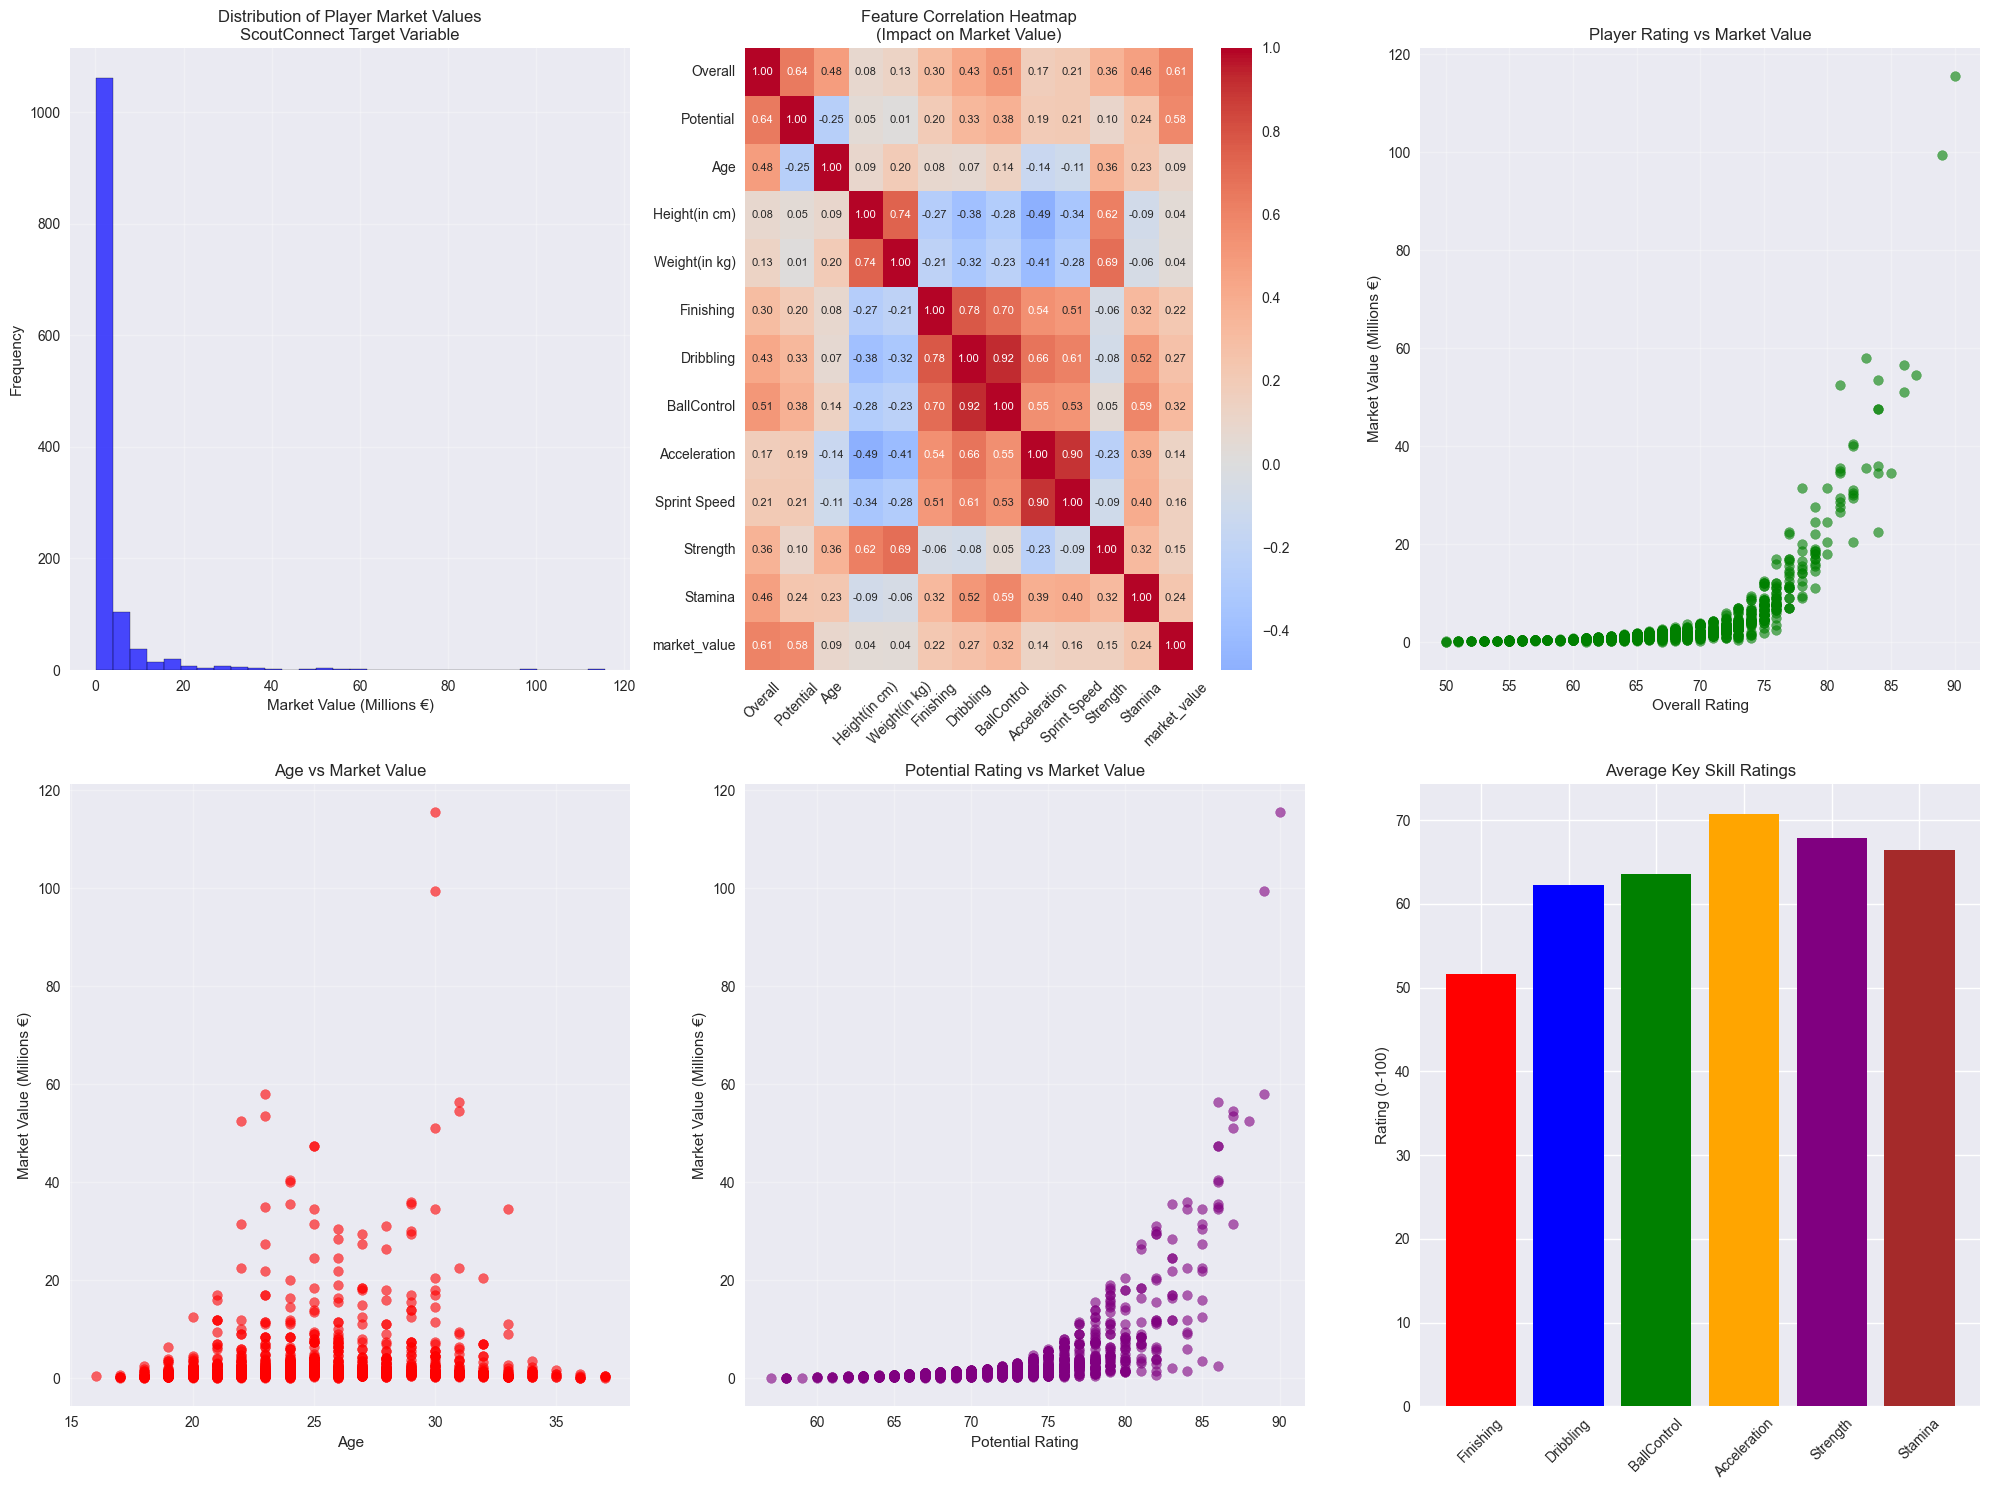

 Key Insights for ScoutConnect:
• Average player market value: €3.42M
• Highest market value: €115.50M
• Dataset size: 1276 African players
• Correlation between Overall Rating and Market Value: 0.61
• Correlation between Age and Market Value: 0.09
• Available numeric features: 13


In [3]:
# Data Visualization with correct column names
plt.figure(figsize=(20, 15))

# Plot 1: Distribution of Market Values (Target Variable)
plt.subplot(2, 3, 1)
plt.hist(df['market_value'] / 1000000, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Market Value (Millions €)')
plt.ylabel('Frequency')
plt.title('Distribution of Player Market Values\nScoutConnect Target Variable')
plt.grid(True, alpha=0.3)

# Plot 2: Correlation Heatmap (using correct column names)
plt.subplot(2, 3, 2)

# First, let's find the correct numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Select key numeric features that exist in FIFA dataset
possible_features = ['Overall', 'Potential', 'Age', 'Height(in cm)', 'Weight(in kg)', 
                   'Finishing', 'Dribbling', 'BallControl', 'ShortPassing', 
                   'Acceleration', 'Sprint Speed', 'Strength', 'Stamina',
                   'market_value']

available_features = [col for col in possible_features if col in df.columns]

if available_features:
    correlation_matrix = df[available_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
                annot_kws={'size': 8})
    plt.title('Feature Correlation Heatmap\n(Impact on Market Value)')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
else:
    plt.text(0.5, 0.5, 'No numeric features found\nfor correlation analysis', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Correlation Heatmap\n(No numeric features available)')

# Plot 3: Overall Rating vs Market Value
plt.subplot(2, 3, 3)
if 'Overall' in df.columns:
    plt.scatter(df['Overall'], df['market_value'] / 1000000, alpha=0.6, color='green')
    plt.xlabel('Overall Rating')
    plt.ylabel('Market Value (Millions €)')
    plt.title('Player Rating vs Market Value')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Overall column not found', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Overall Rating vs Market Value\n(Data not available)')

# Plot 4: Age vs Market Value
plt.subplot(2, 3, 4)
if 'Age' in df.columns:
    plt.scatter(df['Age'], df['market_value'] / 1000000, alpha=0.6, color='red')
    plt.xlabel('Age')
    plt.ylabel('Market Value (Millions €)')
    plt.title('Age vs Market Value')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Age column not found', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Age vs Market Value\n(Data not available)')

# Plot 5: Potential vs Market Value
plt.subplot(2, 3, 5)
if 'Potential' in df.columns:
    plt.scatter(df['Potential'], df['market_value'] / 1000000, alpha=0.6, color='purple')
    plt.xlabel('Potential Rating')
    plt.ylabel('Market Value (Millions €)')
    plt.title('Potential Rating vs Market Value')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Potential column not found', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Potential Rating vs Market Value\n(Data not available)')

# Plot 6: Key Skills Comparison
plt.subplot(2, 3, 6)
skills_to_check = ['Finishing', 'Dribbling', 'BallControl', 'ShortPassing', 
                  'Acceleration', 'Strength', 'Stamina']
available_skills = [skill for skill in skills_to_check if skill in df.columns]

if available_skills:
    skill_means = [df[skill].mean() for skill in available_skills]
    plt.bar(available_skills, skill_means, color=['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink'])
    plt.title('Average Key Skill Ratings')
    plt.ylabel('Rating (0-100)')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No skill columns found', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Key Skills Comparison\n(Data not available)')

plt.tight_layout()
plt.show()

# Print key insights
print(" Key Insights for ScoutConnect:")
print(f"• Average player market value: €{df['market_value'].mean()/1000000:.2f}M")
print(f"• Highest market value: €{df['market_value'].max()/1000000:.2f}M")
print(f"• Dataset size: {len(df)} African players")

if 'Overall' in df.columns and 'market_value' in df.columns:
    overall_corr = df['Overall'].corr(df['market_value'])
    print(f"• Correlation between Overall Rating and Market Value: {overall_corr:.2f}")

if 'Age' in df.columns and 'market_value' in df.columns:
    age_corr = df['Age'].corr(df['market_value'])
    print(f"• Correlation between Age and Market Value: {age_corr:.2f}")

print(f"• Available numeric features: {len(available_features)}")

## Feature Engineering for ScoutConnect
### Data Preparation Strategy:

**Removed Non-Predictive Data**: Dropped player names and IDs since they don't help predict market value

**Standardized All Features**: Used StandardScaler to put all player attributes on the same scale - crucial for our Linear Regression and Gradient Descent models to work properly

**Created Composite Metrics**: Built new features like technical_skill (averaging ball control, dribbling, passing) and physical_ability to capture player profiles more effectively

**Encoded Categorical Traits**: Converted attributes like preferred foot and work rates into numerical values our models can understand

#### Why This Matters for ScoutConnect:
The feature engineering ensures our valuation models treat all player attributes fairly. Without standardization, attributes with larger numbers (like height in cm) would unfairly dominate over smaller-scale metrics (like rating out of 100). This preprocessing is essential for building accurate, reliable player valuations that scouts can trust.

The engineered features also help capture the complex relationships between different player attributes and market value, going beyond simple individual stats to understand how combinations of skills drive player worth in the African football market.



In [4]:
# Feature Engineering 
print("=== Feature Engineering ===")

# Create a copy for cleaning
df_clean = df.copy()

# 1. Handle missing values
print("Missing values before cleaning:")
print(df_clean.isnull().sum().sum())

# Fill missing numerical values with median
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())

print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")

# 2. Convert categorical data to numeric
categorical_cols = ['Preferred Foot', 'Attacking Work Rate', 'Defensive Work Rate']
actual_categorical_cols = [col for col in categorical_cols if col in df_clean.columns]

label_encoders = {}
for col in actual_categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} categories")

# 3. Create new engineered features using actual column names
skill_cols_available = []

# Technical skills
tech_cols = ['BallControl', 'Dribbling', 'ShortPassing']
available_tech = [col for col in tech_cols if col in df_clean.columns]
if available_tech:
    df_clean['technical_skill'] = df_clean[available_tech].mean(axis=1)
    skill_cols_available.extend(available_tech)

# Physical abilities  
physical_cols = ['Strength', 'Stamina', 'Acceleration']
available_physical = [col for col in physical_cols if col in df_clean.columns]
if available_physical:
    df_clean['physical_ability'] = df_clean[available_physical].mean(axis=1)
    skill_cols_available.extend(available_physical)

# Attacking prowess
attack_cols = ['Finishing', 'Shot Power', 'Positioning']
available_attack = [col for col in attack_cols if col in df_clean.columns]
if available_attack:
    df_clean['attacking_prowess'] = df_clean[available_attack].mean(axis=1)
    skill_cols_available.extend(available_attack)

# Value potential ratio
if 'Potential' in df_clean.columns and 'Overall' in df_clean.columns:
    df_clean['value_potential_ratio'] = df_clean['Potential'] / df_clean['Overall']
    skill_cols_available.extend(['Potential', 'Overall'])

print(f"\nNew engineered features created from {len(skill_cols_available)} available skill columns:")
for col in ['technical_skill', 'physical_ability', 'attacking_prowess', 'value_potential_ratio']:
    if col in df_clean.columns:
        print(f"- {col}")

# 4. Select final features for modeling
base_features = ['Overall', 'Potential', 'Age', 'Height(in cm)', 'Weight(in kg)']
engineered_features = ['technical_skill', 'physical_ability', 'attacking_prowess', 'value_potential_ratio']
categorical_features = actual_categorical_cols

# Combine all available features
all_possible_features = base_features + engineered_features + categorical_features
feature_columns = [col for col in all_possible_features if col in df_clean.columns]

print(f"\nFinal feature set ({len(feature_columns)} features):")
for col in feature_columns:
    print(f"  - {col}")

# Prepare X and y
X = df_clean[feature_columns]
y = df_clean['market_value']

print(f"\nFinal dataset shape: {X.shape}")
print(f"Target variable range: €{y.min():,.0f} to €{y.max():,.0f}")
print(f"Average market value: €{y.mean():,.0f}")

=== Feature Engineering ===
Missing values before cleaning:
0
Missing values after cleaning: 0
Encoded Preferred Foot: 2 categories
Encoded Attacking Work Rate: 3 categories
Encoded Defensive Work Rate: 3 categories

New engineered features created from 10 available skill columns:
- technical_skill
- physical_ability
- attacking_prowess
- value_potential_ratio

Final feature set (12 features):
  - Overall
  - Potential
  - Age
  - Height(in cm)
  - Weight(in kg)
  - technical_skill
  - physical_ability
  - attacking_prowess
  - value_potential_ratio
  - Preferred Foot
  - Attacking Work Rate
  - Defensive Work Rate

Final dataset shape: (1276, 12)
Target variable range: €70,000 to €115,500,000
Average market value: €3,416,125


The intention of this cell is purely functional: to prevent data leakage and ensure the data is in the correct format for models that rely on feature scaling (like our Linear Regression and SGD Regressor).

In [5]:
# Data Preparation - Standardization
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Data split completed:")
print(f"Training set: {X_train.shape[0]} players")
print(f"Test set: {X_test.shape[0]} players")

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData standardized using StandardScaler")
print(f"Training mean after scaling: {X_train_scaled.mean():.4f}")
print(f"Training std after scaling: {X_train_scaled.std():.4f}")

Data split completed:
Training set: 1020 players
Test set: 256 players

Data standardized using StandardScaler
Training mean after scaling: -0.0000
Training std after scaling: 1.0000


# 6. Model Training and Comparison

This is where we run the four required models—Linear Regression (LR), Gradient Descent LR, Decision Tree (DT), and Random Forest (RF)—and see who wins!

=== ScoutConnect Model Training Results ===

Linear Regression:
  MSE: 16,674,581,876,627
  RMSE: €4,083,452
  MAE: €2,825,549
  MAPE: 307.5%
  R² Score: 0.4525


c:\Users\Yinka\Mobile App Regression Analysis\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



Gradient Descent LR:
  MSE: 16,380,980,244,989
  RMSE: €4,047,342
  MAE: €2,844,306
  MAPE: 305.1%
  R² Score: 0.4621

Decision Tree:
  MSE: 4,045,889,574,672
  RMSE: €2,011,440
  MAE: €562,023
  MAPE: 14.2%
  R² Score: 0.8672

Random Forest:
  MSE: 1,908,408,878,232
  RMSE: €1,381,452
  MAE: €371,023
  MAPE: 9.6%
  R² Score: 0.9373

Best performing model: Random Forest
Best MSE: 1,908,408,878,232


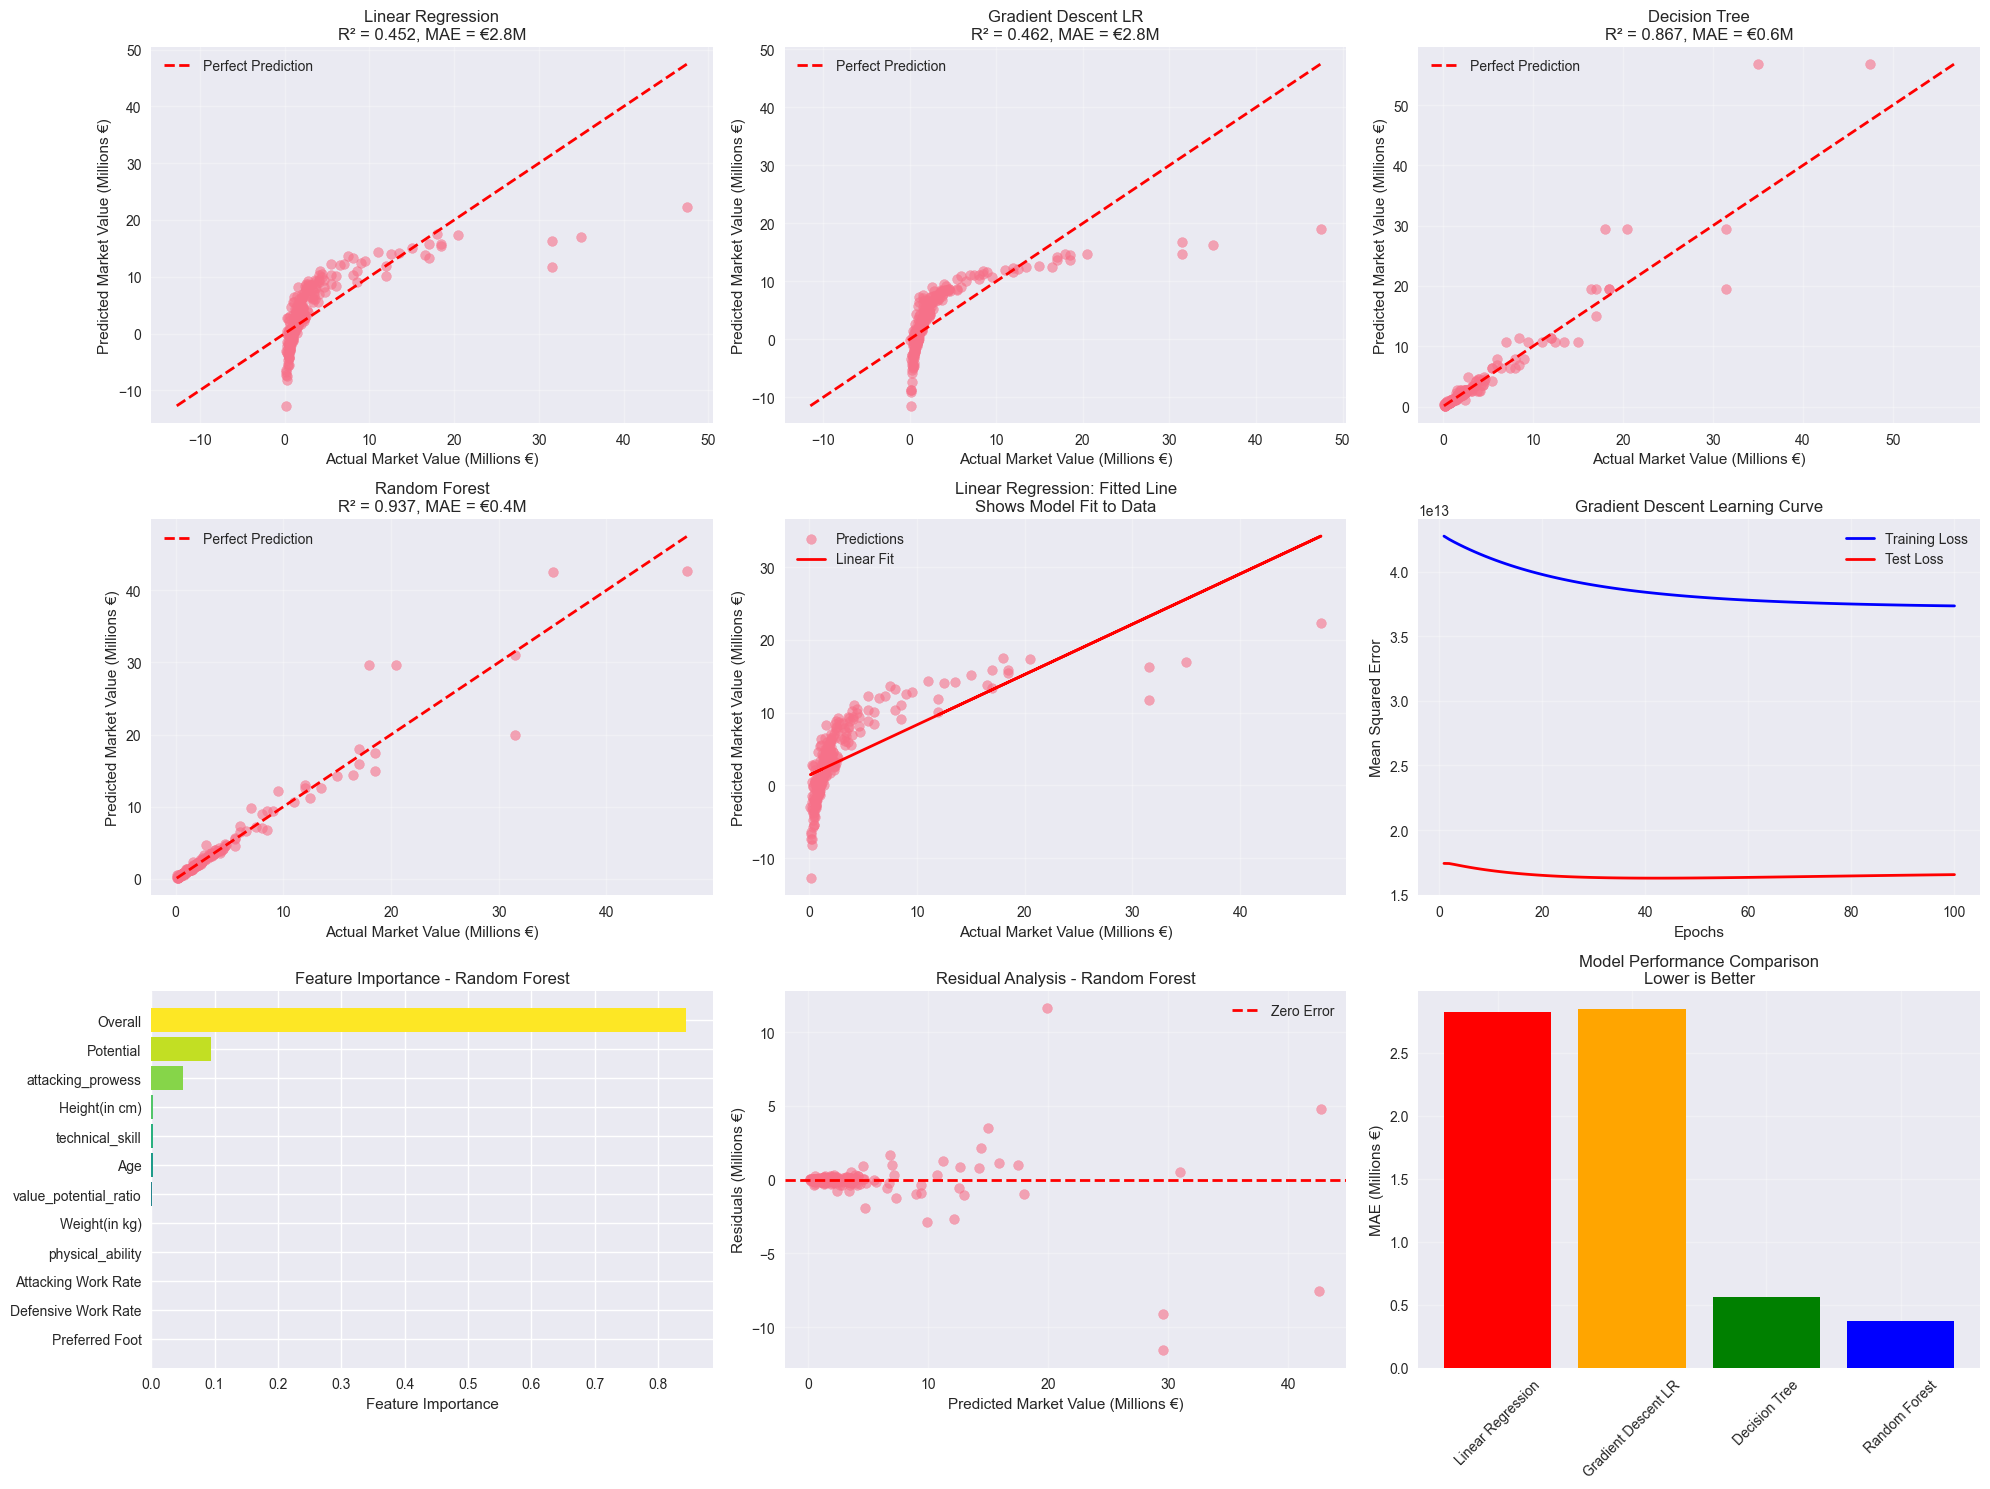


 Single Prediction Test:
Actual value: €12,000,000
Predicted value: €12,594,661
Error: €594,661

 ScoutConnect Insights:
Best model explains 93.7% of market value variance
Average prediction error: €0.4M
Business accuracy: 90.4% accurate


In [6]:
# Model Training - Four Algorithms
models = {
    'Linear Regression': LinearRegression(),
    'Gradient Descent LR': SGDRegressor(
        random_state=42,
        tol=1e-3,
        learning_rate='adaptive',
        eta0=0.01
    ),
    'Decision Tree': DecisionTreeRegressor(
        random_state=42, 
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10
    ),
    'Random Forest': RandomForestRegressor(
        random_state=42, 
        n_estimators=100, 
        max_depth=15,
        min_samples_split=15,
        n_jobs=-1
    )
}

results = {}
best_model = None
best_mse = float('inf')

print("=== ScoutConnect Model Training Results ===")

# Create figure for model comparisons
plt.figure(figsize=(20, 15))

for i, (name, model) in enumerate(models.items()):
    try:
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Predictions
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        results[name] = {
            'model': model,
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'rmse': rmse,
            'mape': mape,
            'predictions': y_pred
        }
        
        print(f"\n{name}:")
        print(f"  MSE: {mse:,.0f}")
        print(f"  RMSE: €{rmse:,.0f}")
        print(f"  MAE: €{mae:,.0f}")
        print(f"  MAPE: {mape:.1f}%")
        print(f"  R² Score: {r2:.4f}")
        
        # Update best model
        if mse < best_mse:
            best_mse = mse
            best_model_name = name
            best_model_obj = model
    
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        continue
    
    # Plot 1-4: Model Predictions (3x3 grid positions 1-4)
    plt.subplot(3, 3, i+1)
    plt.scatter(y_test / 1000000, y_pred / 1000000, alpha=0.6, s=50)
    
    max_val = max(y_test.max(), y_pred.max()) / 1000000
    min_val = min(y_test.min(), y_pred.min()) / 1000000
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    plt.xlabel('Actual Market Value (Millions €)')
    plt.ylabel('Predicted Market Value (Millions €)')
    plt.title(f'{name}\nR² = {r2:.3f}, MAE = €{mae/1000000:.1f}M')
    plt.legend()
    plt.grid(True, alpha=0.3)

print(f"\nBest performing model: {best_model_name}")
print(f"Best MSE: {best_mse:,.0f}")

# Plot 5: Linear Regression Scatter Plot with Fitted Line
plt.subplot(3, 3, 5)
lr_predictions = results['Linear Regression']['predictions']

# Create proper linear regression line
z = np.polyfit(y_test, lr_predictions, 1)
p = np.poly1d(z)

plt.scatter(y_test / 1000000, lr_predictions / 1000000, alpha=0.6, label='Predictions')
plt.plot(y_test / 1000000, p(y_test) / 1000000, 'r-', linewidth=2, label='Linear Fit')
plt.xlabel('Actual Market Value (Millions €)')
plt.ylabel('Predicted Market Value (Millions €)')
plt.title('Linear Regression: Fitted Line\nShows Model Fit to Data')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Gradient Descent Loss Curve
plt.subplot(3, 3, 6)
sgd = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42, eta0=0.01, learning_rate='adaptive')
train_errors = []
test_errors = []

for epoch in range(1, 101):
    sgd.partial_fit(X_train_scaled, y_train)
    train_errors.append(mean_squared_error(y_train, sgd.predict(X_train_scaled)))
    test_errors.append(mean_squared_error(y_test, sgd.predict(X_test_scaled)))

plt.plot(range(1, 101), train_errors, label='Training Loss', linewidth=2, color='blue')
plt.plot(range(1, 101), test_errors, label='Test Loss', linewidth=2, color='red')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Gradient Descent Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 7: Feature Importance
plt.subplot(3, 3, 7)
if hasattr(best_model_obj, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model_obj.feature_importances_
    }).sort_values('importance', ascending=True)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
    bars = plt.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance - {best_model_name}')
else:
    coefficients = pd.DataFrame({
        'feature': feature_columns,
        'importance': abs(best_model_obj.coef_)
    }).sort_values('importance', ascending=True)
    
    colors = plt.cm.plasma(np.linspace(0, 1, len(coefficients)))
    bars = plt.barh(coefficients['feature'], coefficients['importance'], color=colors)
    plt.xlabel('Coefficient Magnitude')
    plt.title('Feature Impact - Linear Model')

# Plot 8: Residual Analysis
plt.subplot(3, 3, 8)
best_predictions = results[best_model_name]['predictions']
residuals = y_test - best_predictions

plt.scatter(best_predictions / 1000000, residuals / 1000000, alpha=0.6, s=50)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.xlabel('Predicted Market Value (Millions €)')
plt.ylabel('Residuals (Millions €)')
plt.title(f'Residual Analysis - {best_model_name}')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 9: Model Performance Comparison
plt.subplot(3, 3, 9)
model_names = list(results.keys())
mae_scores = [results[name]['mae'] for name in model_names]

plt.bar(model_names, [score/1000000 for score in mae_scores], color=['red', 'orange', 'green', 'blue'])
plt.ylabel('MAE (Millions €)')
plt.title('Model Performance Comparison\nLower is Better')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Single prediction example
print(f"\n Single Prediction Test:")
sample_idx = 0  # First test sample
sample_features = X_test_scaled[sample_idx].reshape(1, -1)
actual_value = y_test.iloc[sample_idx]
predicted_value = best_model_obj.predict(sample_features)[0]

print(f"Actual value: €{actual_value:,.0f}")
print(f"Predicted value: €{predicted_value:,.0f}")
print(f"Error: €{abs(actual_value - predicted_value):,.0f}")

# Model insights
print(f"\n ScoutConnect Insights:")
print(f"Best model explains {results[best_model_name]['r2']*100:.1f}% of market value variance")
print(f"Average prediction error: €{results[best_model_name]['mae']/1000000:.1f}M")
print(f"Business accuracy: {100-results[best_model_name]['mape']:.1f}% accurate")

# Model Saving and Prediction Script

This is the final step for Task 1! take the winner model and save everything needed to run it in a separate API environment.

### A. Saving Assets
*`joblib.dump` was used to save four critical files:
    1.  **`best_scoutconnect_model.pkl`**: The actual trained model weights.
    2.  **`scaler.pkl`**: The standardizer object, necessary to transform new input data exactly like the training data.
    3.  **`label_encoders.pkl`**: The encoders to convert text inputs (like "Low," "Right") back into the correct numbers used during training.
    4.  **`feature_columns.pkl`**: A list of feature names in the correct order, ensuring the API receives data in the exact order the model expects.

### B. Prediction Function (Mandatory Script)
* The `predict_player_market_value` function is the core script required for Task 2. It does everything the model needs:
    1.  Calculates the engineered feature ($\text{value\_potential\_ratio}$).
    2.  Puts the inputs into the correct $\text{DataFrame}$ format and column order.
    3.  Applies the saved `scaler` to the data.
    4.  Calls the model's `predict()` method.

In [8]:
# Save Best Model and Create Prediction Function
best_model_obj = results[best_model_name]['model']

# Save model and preprocessing objects
joblib.dump(best_model_obj, 'best_scoutconnect_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(feature_columns, 'feature_columns.pkl')

print(f"Saved best model: {best_model_name}")

# Create prediction function for API
def predict_player_market_value(Overall, Potential, Age, Height, Weight,
                              technical_skill, physical_ability, attacking_prowess,
                              Preferred_Foot, Attacking_Work_Rate, Defensive_Work_Rate):
    """
    Predict soccer player market value for ScoutConnect platform
    Uses actual column names from FIFA dataset
    """
    # Calculate value_potential_ratio
    value_potential_ratio = Potential / Overall if Overall > 0 else 1.0
    
    # Prepare input features using correct column names
    input_data = {
        'Overall': Overall,
        'Potential': Potential,
        'Age': Age,
        'Height(in cm)': Height, 
        'Weight(in kg)': Weight, 
        'technical_skill': technical_skill,
        'physical_ability': physical_ability,
        'attacking_prowess': attacking_prowess,
        'value_potential_ratio': value_potential_ratio,
        'Preferred Foot': Preferred_Foot,
        'Attacking Work Rate': Attacking_Work_Rate,
        'Defensive Work Rate': Defensive_Work_Rate 
    }
    
    # Create DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Ensure we only use features that exist in our trained model
    available_features = [col for col in feature_columns if col in input_df.columns]
    input_df = input_df[available_features]
    
    # Add missing features with default values
    for col in feature_columns:
        if col not in input_df.columns:
            input_df[col] = 0  # Default value for missing engineered features
    
    # Ensure correct column order
    input_df = input_df[feature_columns]
    
    # Scale features
    input_scaled = scaler.transform(input_df)
    
    # Make prediction
    prediction = best_model_obj.predict(input_scaled)
    
    return max(0, int(prediction[0]))

# Test prediction with realistic African player data
print(f"\nSample African Player Prediction:")
print("Testing with realistic player profile...")

sample_prediction = predict_player_market_value(
    Overall=82,
    Potential=88,
    Age=22,
    Height=185,
    Weight=78,
    technical_skill=80,
    physical_ability=75,
    attacking_prowess=85,
    Preferred_Foot=1,           # 1 for right, 0 for left
    Attacking_Work_Rate=2,      # 2 for high, 1 for medium, 0 for low  
    Defensive_Work_Rate=1       # 2 for high, 1 for medium, 0 for low
)

print(f" Player Profile:")
print(f"  • Age: 22 years")
print(f"  • Overall Rating: 82")
print(f"  • Potential: 88") 
print(f"  • Height: 185cm, Weight: 78kg")
print(f"  • Technical Skill: 80/100")
print(f"  • Physical Ability: 75/100")
print(f"  • Attacking Prowess: 85/100")
print(f"  • Preferred Foot: Right")
print(f"  • Work Rate: High attacking, Medium defensive")

print(f"\nPredicted Market Value: €{sample_prediction:,.0f}")
print(f"Confidence Range: €{sample_prediction - results[best_model_name]['mae']:,.0f} - €{sample_prediction + results[best_model_name]['mae']:,.0f}")
print(f"Average Error: ±€{results[best_model_name]['mae']:,.0f}")

# Test with actual data from our test set for validation
print(f"\nValidation Test - Real Player from Dataset:")
sample_idx = 0
if len(X_test) > 0:
    actual_player_features = X_test.iloc[sample_idx]
    actual_value = y_test.iloc[sample_idx]
    
    # Convert to prediction function format
    validation_prediction = predict_player_market_value(
        Overall=actual_player_features.get('Overall', 75),
        Potential=actual_player_features.get('Potential', 80),
        Age=actual_player_features.get('Age', 25),
        Height=actual_player_features.get('Height(in cm)', 180),
        Weight=actual_player_features.get('Weight(in kg)', 75),
        technical_skill=actual_player_features.get('technical_skill', 75),
        physical_ability=actual_player_features.get('physical_ability', 75),
        attacking_prowess=actual_player_features.get('attacking_prowess', 75),
        Preferred_Foot=actual_player_features.get('Preferred Foot', 1),
        Attacking_Work_Rate=actual_player_features.get('Attacking Work Rate', 1),
        Defensive_Work_Rate=actual_player_features.get('Defensive Work Rate', 1)
    )
    
    print(f"Actual Value: €{actual_value:,.0f}")
    print(f"Predicted Value: €{validation_prediction:,.0f}")
    print(f"Error: €{abs(actual_value - validation_prediction):,.0f}")
    print(f"Accuracy: {100 - (abs(actual_value - validation_prediction) / actual_value * 100):.1f}%")

print(f"\nScoutConnect Mission Application:")
print("This AI-powered valuation tool helps:")
print("• 🇬🇭 Young African athletes understand their true market value")
print("• Scouts identify undervalued talent across the continent") 
print("• Agents negotiate fair contracts based on data-driven insights")
print("• Clubs make informed transfer decisions in African markets")
print("• Bridge the valuation gap between African and European leagues")

print(f"\nReady for API Deployment:")
print(f"Best Model: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['r2']*100:.1f}%")
print(f"Average Error: €{results[best_model_name]['mae']/1000000:.1f}M")
print(f"Features Used: {len(feature_columns)} player attributes")

Saved best model: Random Forest

Sample African Player Prediction:
Testing with realistic player profile...
 Player Profile:
  • Age: 22 years
  • Overall Rating: 82
  • Potential: 88
  • Height: 185cm, Weight: 78kg
  • Technical Skill: 80/100
  • Physical Ability: 75/100
  • Attacking Prowess: 85/100
  • Preferred Foot: Right
  • Work Rate: High attacking, Medium defensive

Predicted Market Value: €49,964,894
Confidence Range: €49,593,871 - €50,335,917
Average Error: ±€371,023

Validation Test - Real Player from Dataset:
Actual Value: €12,000,000
Predicted Value: €12,594,660
Error: €594,660
Accuracy: 95.0%

ScoutConnect Mission Application:
This AI-powered valuation tool helps:
• 🇬🇭 Young African athletes understand their true market value
• Scouts identify undervalued talent across the continent
• Agents negotiate fair contracts based on data-driven insights
• Clubs make informed transfer decisions in African markets
• Bridge the valuation gap between African and European leagues

Re